In [292]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
import seaborn as sns
from joblib import Parallel, delayed

#### Simple Demonstration of Online Learning

In [245]:
def online_sample_from_task(d=2):
    mu = np.array([1, 1])
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task(n, d=2):
    mu = np.array([-1, 1])
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [3]:
T = 500
n_test = 500

w = np.array([1, 0]) # initialize
X, Y = batch_sample_from_task(n_test)
error = []
for t in range(1, T):
    x, y = online_sample_from_task()
    lr = 0.01
    w = w + lr * x * y
    w = w / np.linalg.norm(w)
    
    Y_hat = np.sign(X @ w)
    error.append(np.mean(Y != Y_hat))

Text(0.5, 0, 'Time')

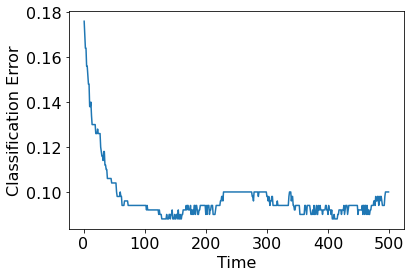

In [4]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 500), error)
ax.set_ylabel("Classification Error")
ax.set_xlabel("Time")

#### Online Learning vs Alternating Task Sequence

In [307]:
def online_sample_from_task_sequence(t, N=20, d=2):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, 1])    
    Y = np.random.binomial(1, 0.5)
    X = np.random.multivariate_normal((-1)**(Y+1)*mu, np.eye(d))
    return X, 2*Y-1

def batch_sample_from_task_sequence(n, t, N=20, d=2, seed=1996):
    if (t // N) % 2 == 0:
        mu = np.array([1, 1])
    else:
        mu = np.array([-1, 1])    
    X = np.concatenate((np.random.multivariate_normal((-1)*mu, np.eye(d), size=n // 2),
                        np.random.multivariate_normal(mu, np.eye(d), size=n // 2)))
    Y = np.concatenate((-np.ones(n // 2), np.ones(n // 2)))
    return X, Y

In [308]:
N = 500
T = 5000
n_test = 1000

w = np.array([1, 0]) # initialize
ogd_error = []
for t in range(1, T):
    x, y = online_sample_from_task_sequence(t, N)
    
    X_test, Y_test = batch_sample_from_task_sequence(n_test, t, N)
    Y_hat = np.sign(X_test @ w)
    ogd_error.append(np.mean(Y_test != Y_hat))

    # online gradient descent algorithm
    lr = 0.01
    w = w + lr * x * y
    w = w / np.linalg.norm(w)

In [309]:
N = 500
T = 5000
n_test = 1000

w = np.array([1, 0]) # initialize
X_train = np.empty((0, 2))
Y_train = np.empty((0,))
ftl_error = []
for t in range(1, T):
    x, y = online_sample_from_task_sequence(t, N)
    
    X_test, Y_test = batch_sample_from_task_sequence(n_test, t, N)
    Y_hat = np.sign(X_test @ w)
    ftl_error.append(np.mean(Y_test != Y_hat))

    # follow the leader algorithm
    X_train = np.concatenate((X_train, x.reshape(1, 2)), axis=0)
    Y_train = np.append(Y_train, y)
    if len(Y_train[Y_train==-1]) >=2 and len(Y_train[Y_train==-1]) >=2:
        m_0 = np.mean(X_train[Y_train==-1], axis=0)
        m_1 = np.mean(X_train[Y_train==1], axis=0)
        S_0 = np.cov(np.array(X_train[Y_train==-1]),rowvar=False)
        S_1 = np.cov(np.array(X_train[Y_train==1]), rowvar=False)
        w = np.linalg.pinv(S_0 + S_1) @ (m_1 - m_0)
        w = w / np.linalg.norm(w)

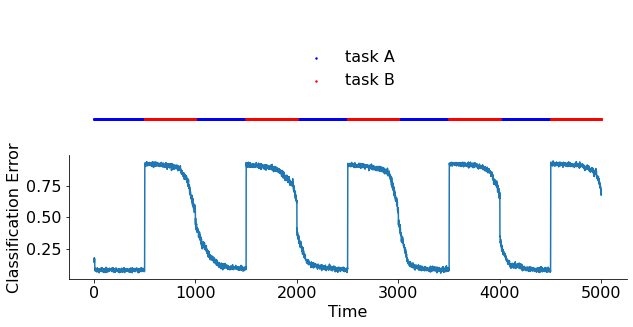

In [129]:
fig, axes = plt.subplots(2, 1, figsize=(10,5))
ax = axes[1]
ax.plot(np.arange(1, T), error)
ax.set_ylabel("Classification Error")
ax.set_xlabel("Time")
ax.spines[['right', 'top']].set_visible(False)

ax = axes[0]
taskA, taskB = [], []
for t in range(1, T):
    if (t // N) % 2 == 0:
        taskA.append(t)
    else:
        taskB.append(t)
ax.scatter(taskA, np.zeros(len(taskA)), c='b',s=2)
ax.scatter(taskB, np.zeros(len(taskB)), c='r',s=2)
ax.set_ylim([-0.01, 0.1])
ax.legend(["task A", "task B"], loc=10, frameon=False)
ax.axis('off')
plt.show()

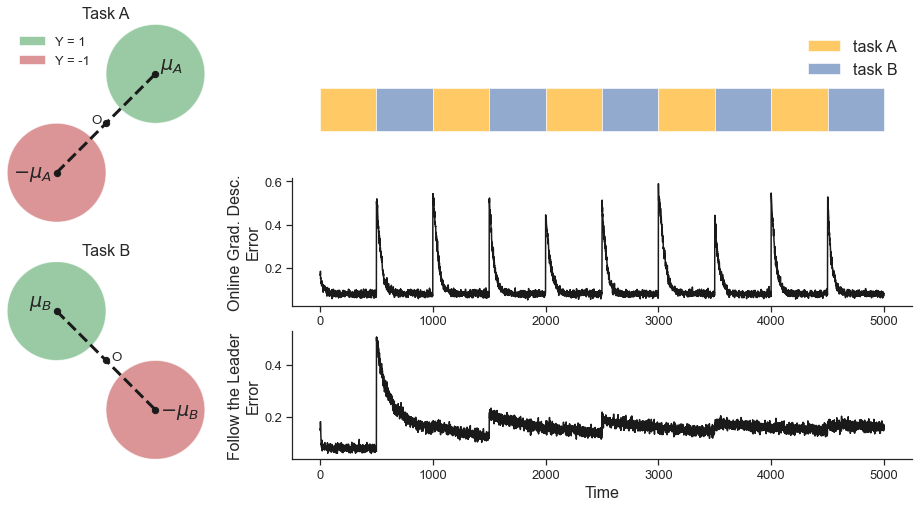

In [311]:
left = [['left1'], 
        ['left2'],]
right = [['right1'],
         ['right2'],
         ['right3'],]
fig, axes = plt.subplot_mosaic([[left, right]], figsize=(20, 8))
ax = axes['left1']
c1 = Circle((1, 1), 1, fc="g", alpha=0.6)
c2 = Circle((-1, -1), 1, fc="r", alpha=0.6)
patches = [c1, c2]
for patch in patches:
    ax.add_artist(patch)
ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.3, 0, "O", size='small')
ax.text(-1.1, -1.1, r"$-\mu_A$", size='large', ha='right')
ax.text(1.1, 1.1, r"$\mu_A$", size='large', ha='left')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect("equal")
ax.set_title("Task A", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['left2']
c1 = Circle((-1, 1), 1, fc="g", alpha=0.6)
c2 = Circle((1, -1), 1, fc="r", alpha=0.6)
patches = [c1, c2]
for patch in patches:
    ax.add_artist(patch)
ax.plot([-1, 1], [1, -1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([-1], [1], c='k', s=40)
ax.scatter([1], [-1], c='k', s=40)
ax.text(0.1, 0, "O", size='small')
ax.text(-1.1, 1.1, r"$\mu_B$", size='large', ha='right')
ax.text(1.1, -1.1, r"$-\mu_B$", size='large', ha='left')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect("equal")
ax.set_title("Task B", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['right1']
xlocs = np.arange(0, T, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes['right2']
ax.plot(np.arange(1, T), ogd_error, c='k')
ax.set_ylabel("Online Grad. Desc." + "\n" + "Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

ax = axes['right3']
ax.plot(np.arange(1, T), ftl_error, c='k')
ax.set_ylabel("Follow the Leader" + "\n" + "Error", fontsize=16)
ax.set_xlabel("Time", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

axes['right1'].set_xlim(ax.get_xlim())

plt.subplots_adjust(wspace=-0.2)
plt.show()

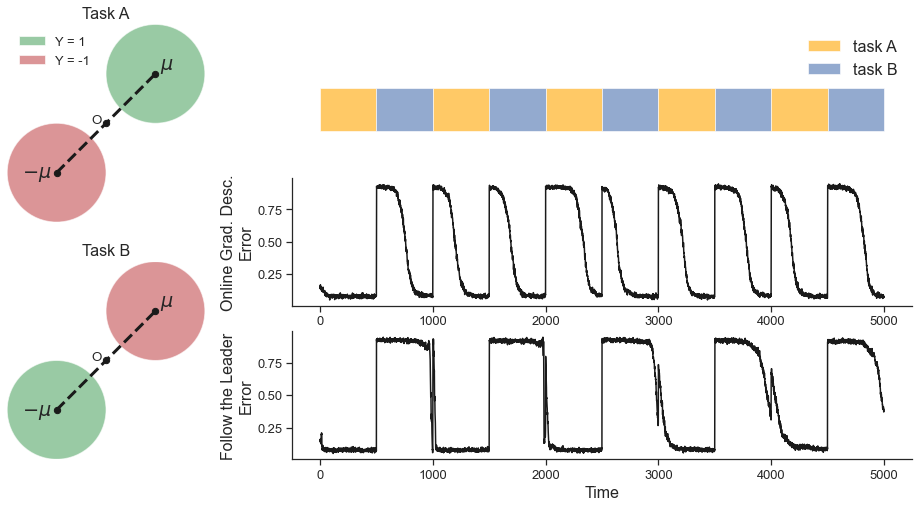

In [306]:
left = [['left1'], 
        ['left2'],]
right = [['right1'],
         ['right2'],
         ['right3'],]
fig, axes = plt.subplot_mosaic([[left, right]], figsize=(20, 8))
ax = axes['left1']
c1 = Circle((1, 1), 1, fc="g", alpha=0.6)
c2 = Circle((-1, -1), 1, fc="r", alpha=0.6)
patches = [c1, c2]
for patch in patches:
    ax.add_artist(patch)
ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.3, 0, "O", size='small')
ax.text(-1.1, -1.1, r"$-\mu$", size='large', ha='right')
ax.text(1.1, 1.1, r"$\mu$", size='large', ha='left')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect("equal")
ax.set_title("Task A", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.legend(["Y = 1", "Y = -1"], fontsize=13, frameon=False, loc=2)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['left2']
c1 = Circle((1, 1), 1, fc="r", alpha=0.6)
c2 = Circle((-1, -1), 1, fc="g", alpha=0.6)
patches = [c1, c2]
for patch in patches:
    ax.add_artist(patch)
ax.plot([-1, 1], [-1, 1], c='k', lw=3, ls="dashed")
ax.scatter([0], [0], c='k', s=40)
ax.scatter([1], [1], c='k', s=40)
ax.scatter([-1], [-1], c='k', s=40)
ax.text(-0.3, 0, "O", size='small')
ax.text(-1.1, -1.1, r"$-\mu$", size='large', ha='right')
ax.text(1.1, 1.1, r"$\mu$", size='large', ha='left')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_aspect("equal")
ax.set_title("Task B", fontsize=16)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax = axes['right1']
xlocs = np.arange(0, T, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes['right2']
ax.plot(np.arange(1, T), ogd_error, c='k')
ax.set_ylabel("Online Grad. Desc." + "\n" + "Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

ax = axes['right3']
ax.plot(np.arange(1, T), ftl_error, c='k')
ax.set_ylabel("Follow the Leader" + "\n" + "Error", fontsize=16)
ax.set_xlabel("Time", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)

axes['right1'].set_xlim(ax.get_xlim())

plt.subplots_adjust(wspace=-0.2)
plt.show()